In [39]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from symengine import *
from mimiqcircuits import *
from tqdm import tqdm
from scipy.optimize import minimize
from quantanium import *
from collections import Counter
import time

sim = Quantanium()

In [40]:
def plot_adjacency_matrix(adj_matrix, title="Adjacency Matrix"):
    plt.figure(figsize=(6,6))
    
    plt.imshow(adj_matrix, cmap='gray_r', interpolation='none')
    plt.title(title)
    plt.colorbar(label="Edge Weight")
    plt.show()

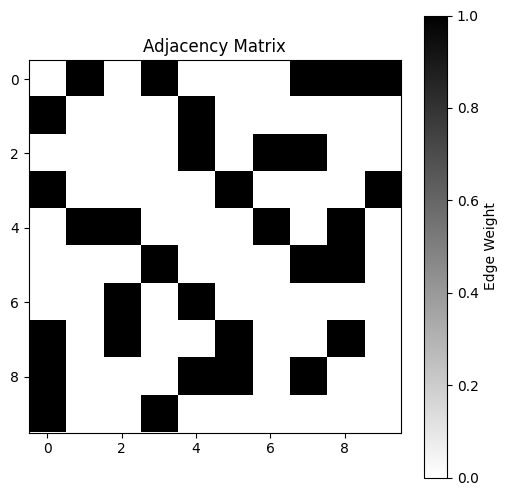

[[0 1 0 1 0 0 0 1 1 1]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 1 0 0]
 [1 0 0 0 0 1 0 0 0 1]
 [0 1 1 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 1 1 0]
 [0 0 1 0 1 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 1 0]
 [1 0 0 0 1 1 0 1 0 0]
 [1 0 0 1 0 0 0 0 0 0]]


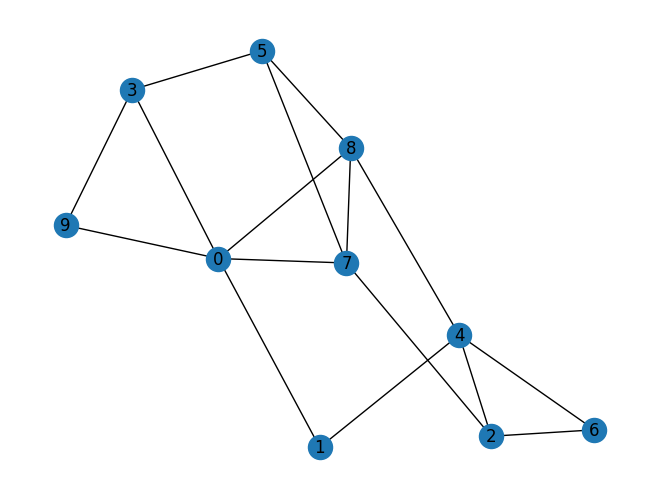

In [41]:
n=10
np.random.seed(1234)
A = np.triu(np.random.randint(0, 2, (n, n)), 1)
adj_martix=A+A.T
plot_adjacency_matrix(adj_martix)
print(adj_martix)
G = nx.Graph(adj_martix)
nx.draw(G, with_labels=True)
def cost(X,A):
    c=np.sum(A,axis=0)
    return X.T @ A @ X-c.T @ X

In [42]:
def Build_QAOA(B, q, draw=False):
    beta=[symbols(f"beta_{i}") for i in range(q)]
    gamma=[symbols(f"gamma_{i}") for i in range(q)]
    n=len(B) #Qubit number

    c=Circuit() #Circuit definition
    c.push(GateH(), range(0, n))
        
    for k in range(0,q):

        #Block here
        for i in range(0,n) :
            for j in range(i+1,n):
                A_ij = B[i,j]
                if A_ij != 0:
                    c.push(GateRZZ(gamma[k]*A_ij), i, j)    #The Upeer one is ALWAYS the control one

        #Block Here
        
        c.push(GateRX(beta[k]), range(0,n))
        
    if draw:
        c.draw()

    return c

In [43]:
def Run_QAOA(circuit, beta, gamma):
   global shots
   dict_beta={f"beta_{i}":beta[i] for i in range(len(beta))}
   dict_gamma={f"gamma_{i}":gamma[i] for i in range(len(gamma))}
   full_dict = {**dict_beta, **dict_gamma}
   ev_circ = circuit.evaluate(full_dict)
   res= sim.execute(ev_circ,nsamples=shots)
   print(res)
   return res

In [44]:
def Optimizer(params):
    global layer_number
    global shots
    global quantum_time
    circuit = Build_QAOA(adj_martix, layer_number)
    
    full_dict = {}
    for i in range(len(params)):
        if i < len(params)/2:
            dict_beta={f"beta_{i}":params[i]}
            full_dict.update(dict_beta)
        else:
            j = i-layer_number
            dict_gamma={f"gamma_{j}":params[i]}
            full_dict.update(dict_gamma)            
    ev_circ = circuit.evaluate(full_dict)
    res= sim.execute(ev_circ,nsamples=shots)
    # Time_execution += res.timings["total"]
    Cost=0
    for state, measures in tqdm( res.histogram().items(), desc="Optimization step"):
        state=np.array(state.tolist())
        Cost+=cost(state,adj_martix)*measures/shots
    return Cost

In [45]:
iteration_cost=[]
def callback(xk):
    iteration_cost.append(Optimizer(xk))


def QAOA(beta_0,gamma_0): 
    global Iterations
    global total_time
    params = np.concatenate([beta_0,gamma_0])
    result = minimize(Optimizer,params,method='Nelder-Mead',options={'maxiter': Iterations},callback=callback)
    return result

In [46]:
layer_number = 2
shots =30000
Iterations=35
total_time = 0
quantum_time = 0

beta_0 = np.random.uniform(0, np.pi, layer_number)
gamma_0 = np.random.uniform(0, np.pi, layer_number)
val=QAOA(beta_0,gamma_0)

params = val.x
best_cost=val.fun

Optimization step: 100%|██████████| 979/979 [00:00<00:00, 113796.24it/s]


In [47]:
print (val,best_cost)

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: -8.822133333333333
             x: [ 2.858e+00  1.233e+00  2.045e+00  2.950e-01]
           nit: 35
          nfev: 68
 final_simplex: (array([[ 2.858e+00,  1.233e+00,  2.045e+00,  2.950e-01],
                       [ 2.873e+00,  1.229e+00,  2.042e+00,  2.956e-01],
                       ...,
                       [ 2.870e+00,  1.231e+00,  2.041e+00,  2.952e-01],
                       [ 2.863e+00,  1.232e+00,  2.041e+00,  2.967e-01]]), array([-8.822e+00, -8.803e+00, -8.794e+00, -8.793e+00,
                       -8.786e+00])) -8.822133333333333


In [48]:
circuit = Build_QAOA(adj_martix, layer_number)

beta_0=params[:len(params)//2]
gamma_0=params[len(params)//2:]
print(beta_0)
res=Run_QAOA(circuit,beta_0,gamma_0)

[2.85798712 1.23300354]
QCSResults:
├── simulator: Quantanium StateVector 1.0
├── timings:
│    ├── apply time: 0.000495477s
│    └── sample time: 0.007701498s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"0010100101" => 384
│    ├── bs"0100001111" => 352
│    ├── bs"1101011010" => 342
│    ├── bs"1011110100" => 327
│    └── bs"0100001011" => 326
├── 1 executions
├── 0 amplitudes
└── 30000 samples


In [49]:

counter = Counter(res.cstates)

most_common_state, frequency = counter.most_common(1)[0]

print(f"Stato più frequente: {most_common_state}, con frequenza: {frequency}")

cost(np.array(most_common_state.tolist()) ,adj_martix)

Stato più frequente: frozenbitarray('0010100101'), con frequenza: 384


np.int64(-9)

In [50]:
# betas=[[np.pi/75*i] for i in range(75)]
# gammas=[[2*np.pi/75*i] for i in range(75)]

In [51]:

# circuit=Build_QAOA(adj_martix, 1)
# points=[]
# for i in range(35):
#     for j in range(35):
#         res=Run_QAOA(circuit,betas[i],gammas[j])
#         points.append(res)

In [52]:
# final=[]
# for point in points:
#     counter = Counter(point.cstates)
#     most_common_state, frequency = counter.most_common(1)[0]
#     final.append(cost(np.array(most_common_state.tolist()), adj_martix))

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(betas, gammas, final)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()


In [53]:
print(len(betas))

NameError: name 'betas' is not defined

In [ ]:
plt.plot(betas, final, marker='o', linestyle='-')  # Aggiunge marker ai punti
plt.xlabel("Gamma values")
plt.ylabel("Function value")
plt.title("Optimization Progress")
plt.grid(True)  # Aggiunge una griglia per migliorare la leggibilità
plt.show()

NameError: name 'final' is not defined

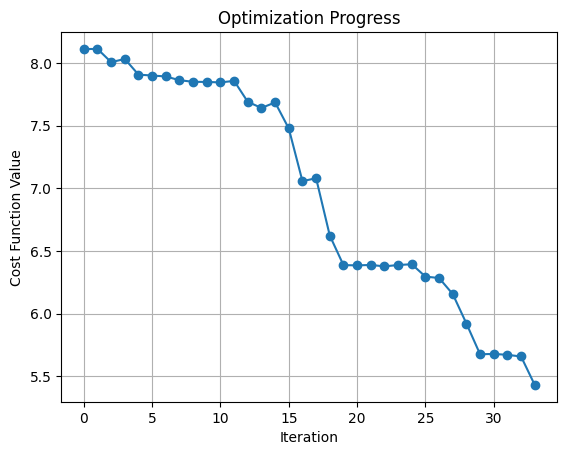

In [ ]:
plt.plot(iteration_cost, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("Optimization Progress")
plt.grid()
plt.show()

In [ ]:
#risolvi il problema per vari p, e trova le rispettive cost function
#usando il metodo dentro plotting.py, plotta il grafico

In [ ]:
#risolvi il problema per vari ansatz, e o li grafichiamo o diciamo semplicemente cosa abbiamo fatto

In [ ]:
#fissati p e ansatz, risolviamo di nuovo il problema per vari numero di qubit, anche con il classic solver (dentro classic_solver.py)
#grafichiamo il tempo impiegato nei vari solver rispetto al numero di qubit, con il metodo xy_plotting

In [ ]:
#scelto un problema (cioe N e ansatz) trovare la soluzione e usare il metodo graph plotting per plottare i due sottografi

In [ ]:
#FINE

In [ ]:
# def Optimizer_v2(circuit,Beta_best,Gamma_best,iteration): 
#     Cost_best= 0
#     for i in tqdm(range(iteration), desc="outer one"):
#         Cost=0
#         beta = Beta_best + np.random.normal(0,0.2)
#         gamma = Gamma_best + np.random.normal(0,0.2)
#         state_vector = Run_QAOA(circuit,beta,gamma,connect).histogram()
#         for state, measures in state_vector.items():
#             state=np.array(state.tolist())
#             Cost+=cost(state,D)*measures
#         if(Cost>Cost_best):
#             Cost_best=Cost
#             Beta_best=beta
#             Gamma_best=gamma
#         if(i==iteration-1):
#             return max(state_vector, key=state_vector.get)
#     return 0

p_values=np.linspace(1,16,8,dtype=int)
Iterations = 15
p_circuits=[]

for p in p_values:
    p_circuits.append(Build_QAOA(adj_martix,p))
    
iteration=1
layer_number = 1
circuit = Build_QAOA(adj_martix, layer_number)


beta_0 = np.random.uniform(0, np.pi, layer_number)
gamma_0 = np.random.uniform(0, np.pi, layer_number)
val_=Optimizer_v2(circuit,beta_0,gamma_0,iteration)

NameError: name 'Optimizer_v2' is not defined

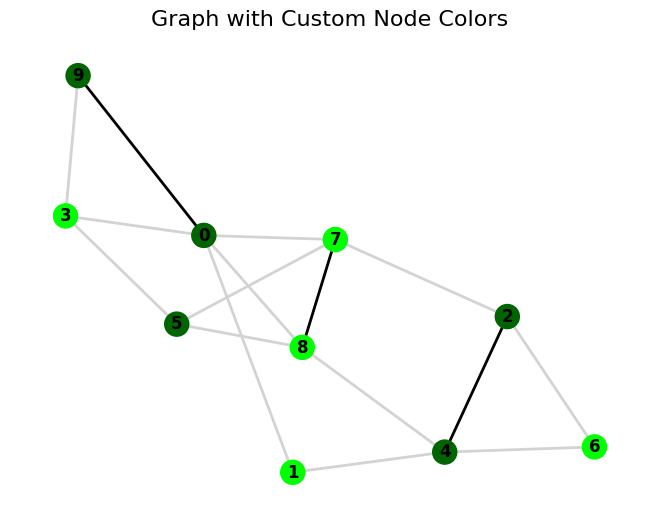

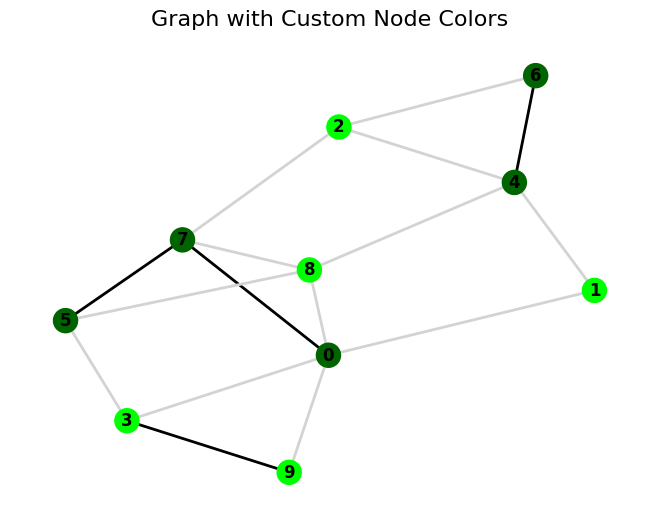

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def xy_plotting(x, y, x_label, y_label, title):
    plt.plot(x, y, label=title, color='blue', marker='o', linestyle='-', linewidth=2)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

def graph_draw(adj_matrix, cut):
    assert(adj_matrix.shape[0]==len(cut))
    G = nx.from_numpy_array(adj_matrix)
    F = G
    node_colors = ['darkgreen' if cut[i] == 1 else 'lime' for i in range(len(cut))]
    link = []
    for i in range(0,len(cut)):
        #print("i:",i)
        for j in range(0,len(cut)):
            #print("j:",j)
            if cut[i] != cut[j] and adj_matrix[i,j] !=0:
                link.append((i,j))

    edge_colors = ['lightgray' if edge in link else 'black' for edge in G.edges()]
    pos = nx.spring_layout(G)
    
    #plt.sca(axes[0])
    #nx.draw(F, pos, with_labels=True, node_size=300, font_size=12, font_weight='bold',
    #        edge_color='black', node_color='green', width=2)
    #plt.sca(axes[1])
    nx.draw(G, pos, with_labels=True, node_size=300, font_size=12, font_weight='bold',
            edge_color=edge_colors, node_color=node_colors, width=2)

    # Optional: Customize the plot appearance
    plt.title('Graph with Custom Node Colors', fontsize=16)
    plt.axis('off')  # Turn off the axis
    plt.show()
    
N = 10

A = np.random.rand(N,N)
A = np.triu(A,1)
B = A + A.T

v= np.array([1,0,1,0,1,1,0,0,0,1])
v1=np.array([1,0,0,0,1,1,1,1,0,0])
C= np.array([[0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
 [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 1, 1, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
 [1, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]]
)

graph_draw(C,v)
graph_draw(C,v1)